## Explore parcel data

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

sys.path.append("../utils")

# user = "leilanie"
# util_path = f"/capstone/wildfire_prep/{user}/data-preparation/code/utils"
# sys.path.append(util_path)

import config

In [2]:
gbd_path = os.path.join(config.data_dir, "parcel_boundaries", "cbiinputs.gdb")

In [3]:
# Read in parcel data
parcels = gpd.read_file(gbd_path)
parcels = parcels.to_crs(config.geodetic_crs)
print("Parcels CRS:", parcels.crs)

Parcels CRS: EPSG:4326


<Axes: >

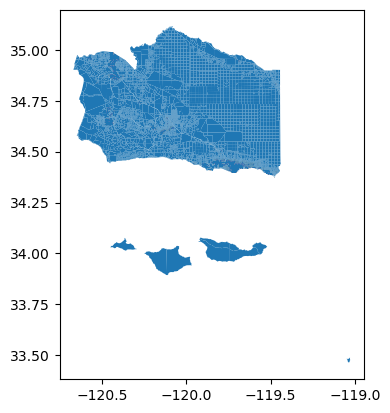

In [4]:
parcels.plot()

Text(0, 0.5, 'Frequency')

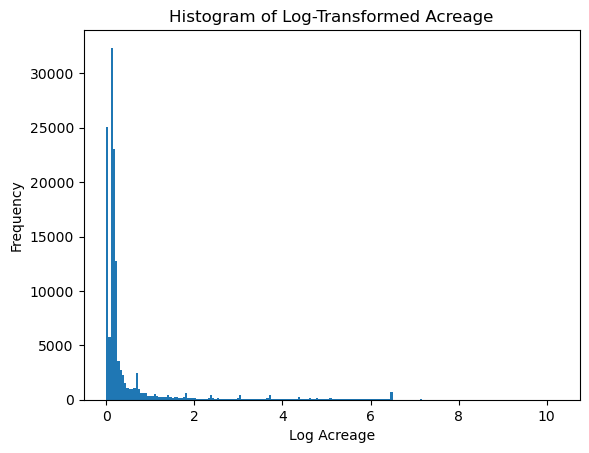

In [5]:
# Exploratory plots

# Parcel area
parcels["log_acreage"] = np.log(parcels.acreage + 1)
parcels.log_acreage.plot.hist(bins=200)
plt.title("Histogram of Log-Transformed Acreage")
plt.xlabel("Log Acreage")
plt.ylabel("Frequency")

## Inspections  data

In [6]:
inspection_fp = os.path.join(
    config.data_dir,
    "inspections_data",
    "2022_defensible_space_inspections_SBC",
    "2022_defensible_space_inspections_SBC.shp",
)

pd.set_option("display.max_columns", None)

inspection_2022 = gpd.read_file(inspection_fp)
inspection_2022.head()

,fulcrum_id,created_at,updated_at,system_cre,system_upd,version,status,project,assigned_t,latitude,longitude,report_tit,globalid,keyid,propertyst,inspection,inspectorp,inspecti_1,addressvis,address_su,address_th,address__1,address_lo,address__2,address_ad,address_po,address_co,address_fu,calfireuni,county,community,community_,battalion,enginenumb,stationnam,shift,shift_juli,accessegre,occupantho,deliveryno,inspecti_2,a_removebr,b_removele,c_removede,d_removede,e_removefl,f_removefl,g_relocate,h_cutannua,i_removefu,j_exposedw,k_removede,l_removelo,m_outbuild,n_displaya,o_stovepip,recommendc,waterstora,water_sour,can_engine,water_stor,water_comm,structuret,structureh,roofconstr,eaves,ventscreen,exteriorsi,windowpane,deckporchg,deckporche,patiocover,fenceattac,propanetan,utilitymis,utilitym_1,nonhabitab,escalateto,reinspecti,citationnu,number_of_,photoid,photoid_ca,le100numbe,inspecti_3,coredata,firescopei,apn,yearbuilt,siteaddres,numberofst,appenddate,editstatus,calculated,calculat_1,calculat_2,textfield1,textfield2,numberfiel,numberfi_1,previousyr,previous_1,calculat_3,calculat_4,creationda,editdate,creator,editor,Date,geometry
0,48c58877-f0ce-438d-ac87-6434a2c15fe8,2022-02-14 10:44:17 PST,2022-05-24 12:22:14 PDT,2022-02-14 10:44:17 PST,2022-05-24 12:22:23 PDT,8.0,Compliant,None,None,34.461625,-119.772555,Defensible Space Inspection Report,None,NaN,None,None,Engine,2022-05-24,Yes - Without Reflective,4440,Shadow Hills Cir,None,Santa Barbara,Santa Barbara,CA,93105,US,4440 Shadow Hills Cir Santa Barbara Santa Barb...,SBC,SBA,San Marcos Foothills,None,1,NaN,13,A,144,Yes,No,Mailed,15,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,yes,Hydrant- Municipal/Public Water Supply,yes,None,None,Multi Family Residence Multi Story,Habitable,Tile,Enclosed,"Mesh Screen <= 1/8""",Other,Single Pane,Masonry/Concrete,Masonry/Concrete,Non Combustible,No Fence,Not Applicable,None,0,0,None,None,None,0.0,"eb994fe9-6273-444c-95b7-c3633b0876f5,de1dc62a-...",",,",NaN,NaN,None,None,None,NaN,None,NaN,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,2022-02-14,2022-02-14,None,None,2022-05-24,POINT (-119.77256 34.46163)
1,2f9d4c7c-54cb-415d-aae4-57f9b6c18994,2022-02-28 16:11:51 PST,2022-10-25 11:33:18 PDT,2022-02-28 16:11:51 PST,2022-10-25 11:34:34 PDT,6.0,Compliant,None,None,34.446105,-119.720859,Defensible Space Inspection Report,None,NaN,None,None,DSI,2022-10-25,Yes - Without Reflective,2928,La Combadura Rd,None,Santa Barbara,Santa Barbara,CA,93105,US,2928 La Combadura Rd Santa Barbara Santa Barba...,SBC,SBA,Mission Canyon,None,1,NaN,15,C,298,Yes,No,Email,15,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,yes,Hydrant- Municipal/Public Water Supply,yes,None,None,Single Family Residence Single Story,Habitable,Asphalt,Unenclosed,"Mesh Screen <= 1/8""",Stucco/Brick/Cement,Multi Pane,No Deck/Porch,No Deck/Porch,No Patio Cover/Carport,Not Observed,Not Applicable,<30',1,None,None,None,None,0.0,None,None,NaN,NaN,None,None,None,NaN,None,NaN,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,2022-02-28,2022-02-28,None,None,2022-10-25,POINT (-119.72086 34.4461)
2,f351800c-fc5c-4b79-bf24-a41775b74d7c,2022-04-05 13:47:06 PDT,2022-09-05 13:47:11 PDT,2022-04-05 13:47:06 PDT,2022-09-05 13:55:48 PDT,4.0,Compliant,None,None,34.672591,-120.108711,Defensible Space Inspection Report,None,0.0,None,None,DSI,2022-08-31,Yes - Without Reflective,3110 A,Acampo Rd,None,Santa Ynez,Santa Barbara,CA,93441,US,3110 A Acampo Rd Santa Ynez Santa Barbara CA 9...,SBC,SBA,Los Olivos,None,3,32.0,Santa Ynez Valley (Outside Engine Co. Area),C,248,Yes,No,Hardcopy,15,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,yes,Hydrant- Municipal/Public Water Supply,yes,None,None,Single Family Residence Single Story,Habitable,Tile,Unenclosed,No Vents,Stucco/Brick/Cement,Single Pane,Masonry/Concrete,No Deck/Porch,Combustible,Combustible,Not Applicable,None,0,0,None,None,None,0.0,None,None

In [7]:
# Check compliance status counts
inspection_2022["status"].value_counts()

status
Compliant                                        13478
Uninspected (Locked Gate)                          776
Due for Inspection                                 290
Compliant 6 months - 1 year                        104
Incomplete Data or Never Inspected                  70
1st Non Compliant                                   56
Structure Destroyed                                 11
3rd Non Compliant                                    3
2nd Non Compliant                                    1
AB-38 Request (please complete within 5 days)        1
Name: count, dtype: int64

<Axes: >

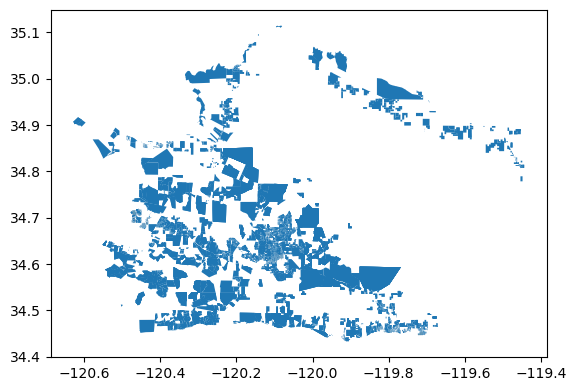

In [8]:
# Join the parcel data to the inspections data
parcels = parcels.to_crs(inspection_2022.crs)
joined_2022 = gpd.sjoin(parcels, inspection_2022, how="inner", predicate="contains")
joined_2022.plot()

In [12]:
# Get the counts of parcels that are compliant and non-compliant
inspection_2022["status"].value_counts()

status
Compliant                                        13478
Uninspected (Locked Gate)                          776
Due for Inspection                                 290
Compliant 6 months - 1 year                        104
Incomplete Data or Never Inspected                  70
1st Non Compliant                                   56
Structure Destroyed                                 11
3rd Non Compliant                                    3
2nd Non Compliant                                    1
AB-38 Request (please complete within 5 days)        1
Name: count, dtype: int64

In [9]:
# Simplify categories
status_map = {
    "Compliant": "Compliant",
    "Compliant 6 months - 1 year": "Compliant",
    "1st Non Compliant": "Non-Compliant",
    "2nd Non Compliant": "Non-Compliant",
    "3rd Non Compliant": "Non-Compliant",
    "Uninspected (Locked Gate)": "Other",
    "Due for Inspection": "Other",
    "Incomplete Data or Never Inspected": "Other",
    "Structure Destroyed": "Other",
    "AB-38 Request (please complete within 5 days)": "Other",
}

joined_2022["status_simplified"] = joined_2022["status"].map(status_map)

# Check the new categories
print(joined_2022["status_simplified"].value_counts())

status_simplified
Compliant        13749
Other             1144
Non-Compliant       60
Name: count, dtype: int64


<Axes: >

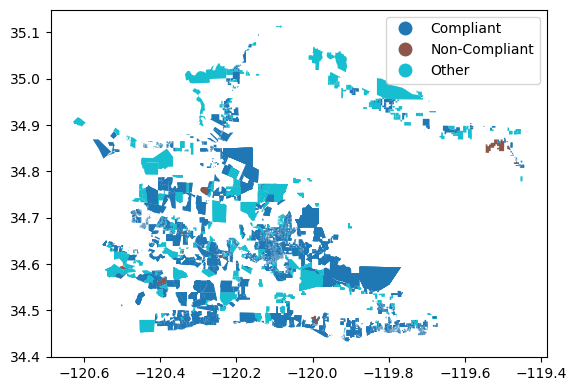

In [10]:
# Plot compliance status by parcel
joined_2022.plot(
    column="status_simplified",
    legend=True,
)

#### Save joined data

located in "data/joined_inspections_parcels"

In [12]:
joined_2022_path = os.path.join(config.data_dir, "joined_inspections_parcels", "joined_2022.geojson")
joined_2022.to_file(joined_2022_path, driver="GeoJSON")

In [18]:
# FIX - This is setting other to noncompliant

# # Set seaborn style
# sns.set_style("white")

# # Create custom colormap
# cmap = colors.ListedColormap(["green", "red"])

# # Create figure and axis
# fig, ax = plt.subplots(figsize=(10, 10))

# # Create the plot
# joined_2022.plot(
#     column="status_simplified",
#     ax=ax,
#     legend=True,
#     cmap=cmap,
#     legend_kwds={"labels": ["Compliant", "Non-Compliant"]},
# )

# # Remove axes
# ax.set_axis_off()

# plt.show()

## Do the above for each year and make one clean summary dataframe.

### 2018 inspection data

In [19]:
# 2018 inspection data
inspection_2018_fp = os.path.join(
    config.data_dir,
    "inspections_data",
    "2018_defensible_space_inspections_SBC",
    "20181231_defensible_space_inspections_SBC.shp",
)

inspection_2018 = gpd.read_file(inspection_2018_fp)
inspection_2018.head()

inspection_2018["status"].value_counts()

status
Incomplete Data or Never Inspected    9404
Due for 2019 Inspection               5763
Not Inspected Since 2017                 1
Name: count, dtype: int64

### 2019 inspection data

In [21]:
# 2019 inspection data
inspection_2019_fp = os.path.join(
    config.data_dir,
    "inspections_data",
    "2019_defensible_space_inspections_SBC",
    "2019_defensible_space_inspections_SBC.shp",
)

inspection_2019 = gpd.read_file(inspection_2019_fp)
inspection_2019.head()

print(inspection_2019["status"].value_counts())

status_map_2019 = {
    "1st Compliant": "Compliant",
    "2nd Compliant": "Compliant",
    "3rd Compliant": "Compliant",
    "1st Non Compliant": "Non-Compliant",
    "2nd Non Compliant": "Non-Compliant",
    "3rd Non Compliant": "Non-Compliant",
    "Incomplete Data or Never Inspected": "Other",
    "Uninspected (Locked Gate)": "Other",
    "Structure Destroyed": "Other",
    "Due for 2019 Inspection": "Other",
}

inspection_2019["status_simplified"] = inspection_2019["status"].map(status_map_2019)

print(inspection_2019["status_simplified"].value_counts())

status
1st Compliant                         14420
Incomplete Data or Never Inspected     1734
Uninspected (Locked Gate)               524
2nd Compliant                           130
1st Non Compliant                        70
2nd Non Compliant                        45
Structure Destroyed                      32
Due for 2019 Inspection                  22
3rd Non Compliant                         8
3rd Compliant                             2
Name: count, dtype: int64
status_simplified
Compliant        14552
Other             2312
Non-Compliant      123
Name: count, dtype: int64


<Axes: >

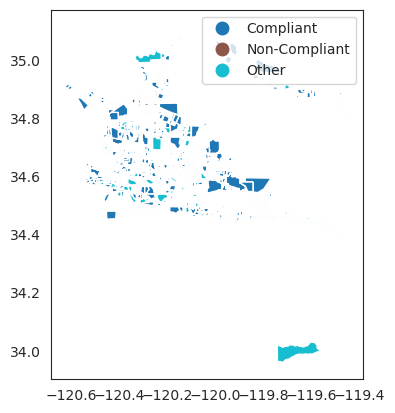

In [22]:
parcels = parcels.to_crs(inspection_2019.crs)
joined = gpd.sjoin(parcels, inspection_2019, how="inner", predicate="contains")
joined.plot(
    column="status_simplified",
    legend=True,
)

### 2020 inspections data

In [23]:
# 2020 inspection data
inspection_2020_fp = os.path.join(
    config.data_dir,
    "inspections_data",
    "2020_defensible_space_inspections_SBC",
    "2020_defensible_space_inspections_SBC.shp",
)

inspection_2020 = gpd.read_file(inspection_2020_fp)
inspection_2020.head()

print(inspection_2020["status"].value_counts())

status_map_2020 = {
    "Compliant": "Compliant",
    "1st Non Compliant": "Non-Compliant",
    "2nd Non Compliant": "Non-Compliant",
    "Citation": "Non-Compliant",
    "Due for Inspection 2020": "Other",
    "Uninspected (Locked Gate)": "Other",
    "Incomplete Data or Never Inspected": "Other",
    "Structure Destroyed": "Other",
}

inspection_2020["status_simplified"] = inspection_2020["status"].map(status_map_2020)

print(inspection_2020["status_simplified"].value_counts())

status
Compliant                             11784
Due for Inspection 2020                2162
Uninspected (Locked Gate)               562
Incomplete Data or Never Inspected      120
1st Non Compliant                        91
Structure Destroyed                      47
2nd Non Compliant                         2
Citation                                  1
Name: count, dtype: int64
status_simplified
Compliant        11784
Other             2891
Non-Compliant       94
Name: count, dtype: int64


### 2021 inspections data

In [24]:
# 2021 inspection data
inspection_2021_fp = os.path.join(
    config.data_dir,
    "inspections_data",
    "2021_defensible_space_inspections_SBC",
    "2021_defensible_space_inspections_SBC.shp",
)

inspection_2021 = gpd.read_file(inspection_2021_fp)
inspection_2021.head()

print(inspection_2021["status"].value_counts())

status_map_2021 = {
    "Compliant": "Compliant",
    "1st Non Compliant": "Non-Compliant",
    "3rd Non Compliant": "Non-Compliant",
    "Due for Inspection 2021": "Other",
    "Uninspected (Locked Gate)": "Other",
    "Incomplete Data or Never Inspected": "Other",
    "Structure Destroyed": "Other",
}

inspection_2021["status_simplified"] = inspection_2021["status"].map(status_map_2021)

print(inspection_2021["status_simplified"].value_counts())

status
Compliant                             13942
Due for Inspection 2021                 306
Uninspected (Locked Gate)               299
Incomplete Data or Never Inspected      190
1st Non Compliant                        69
Structure Destroyed                       9
3rd Non Compliant                         1
Name: count, dtype: int64
status_simplified
Compliant        13942
Other              804
Non-Compliant       70
Name: count, dtype: int64


### 2023 inspections data

### Parcel sizes

#### 2022

In [26]:
# joined_2022.columns.to_list()

<Axes: ylabel='Frequency'>

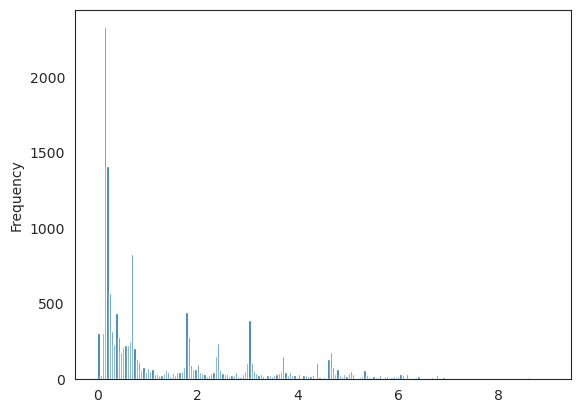

In [27]:
joined_2022.log_acreage.plot.hist(bins=200)

<Axes: ylabel='Frequency'>

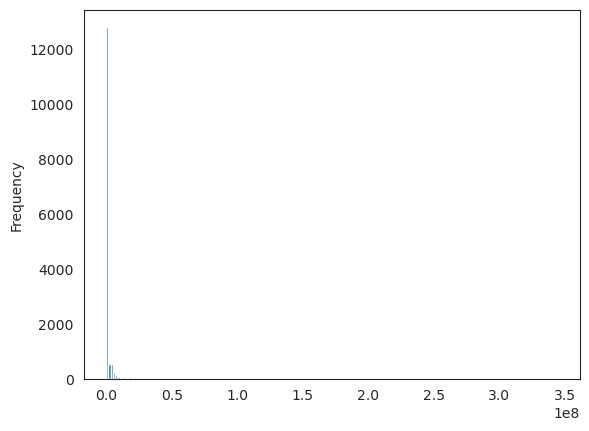

In [29]:
joined_2022.shape_Area.plot.hist(bins=200)

/tmp/ipykernel_52796/3212935917.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  joined_2022.area


<Axes: ylabel='Frequency'>

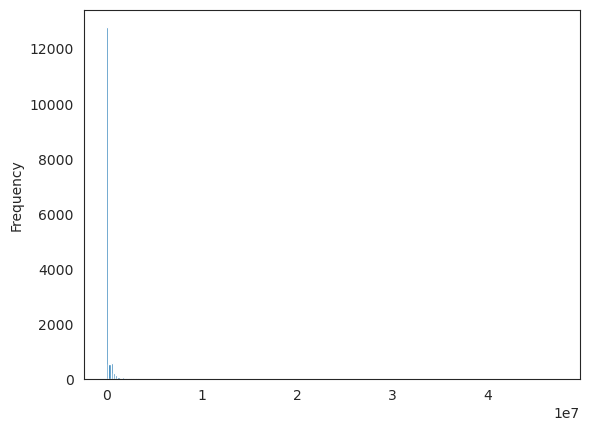

In [28]:
type(joined_2022)
joined_2022.area

joined_2022 = joined_2022.to_crs(3857)

# Create the plot
joined_2022.area.plot.hist(bins=200)
